In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2a.ok')

Assignment: proj2a
OK, version v1.13.11



# Project 2 Part A: Spam/Ham Classification
## EDA, Feature Engineering, Classifier
### The assignment is due on Monday, April 20th at 11:59pm PST.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In project 2, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

In project 2A, you will undersatand the data through EDAs and do some basic feature engineerings. At the end, you will train your first logistic regression model to classify Spam/Ham emails. 

## Warning
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
Total | 15

In project 2a, we will try to undersatand the data and do some basic feature engineerings for classification.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sun Apr 19 02:05:05 2020
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sun Apr 19 02:05:06 2020
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [4]:
original_training_data

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
...,...,...,...,...
8343,8343,Subject: Re: ALSA (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0
8344,8344,Subject: Re: Goodbye Global Warming\n,thanks for the link - i'm fascinated by archae...,0
8345,8345,Subject: hello\n,we need help. we are a 14 year old fortune 50...,1
8346,8346,Subject: Your application is below. Expires Ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1


In [5]:
original_training_data.isna().sum()

id         0
subject    6
email      0
spam       0
dtype: int64

In [6]:
original_training_data['subject'].fillna('', inplace=True)

In [7]:
original_training_data.isna().sum()

id         0
subject    0
email      0
spam       0
dtype: int64

In [8]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [9]:
original_training_data

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0
...,...,...,...,...
8343,8343,Subject: Re: ALSA (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0
8344,8344,Subject: Re: Goodbye Global Warming\n,thanks for the link - i'm fascinated by archae...,0
8345,8345,Subject: hello\n,we need help. we are a 14 year old fortune 50...,1
8346,8346,Subject: Your application is below. Expires Ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1


In [10]:
original_training_data[original_training_data['spam'] == 0]['email'].iloc[0]

'url: http://boingboing.net/#85534171\n date: not supplied\n \n arts and letters daily, a wonderful and dense blog, has folded up its tent due \n to the bankruptcy of its parent company. a&l daily will be auctioned off by the \n receivers. link[1] discuss[2] (_thanks, misha!_)\n \n [1] http://www.aldaily.com/\n [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf\n \n \n'

In [11]:
original_training_data[original_training_data['spam'] == 1]['email'].iloc[0]

'<html>\n <head>\n </head>\n <body>\n <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>\n  better equipped than a man with a 5-6"hammer. <br>\n <br>would you rather have<br>more than enough to get the job done or fall =\n short. it\'s totally up<br>to you. our methods are guaranteed to increase y=\n our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=\n 004">come in here and see how</a>\n </body>\n </html>\n \n \n \n'

In [12]:
first_ham = original_training_data[original_training_data['spam'] == 0]['email'].iloc[0]
first_spam = original_training_data[original_training_data['spam'] == 1]['email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [13]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

One thing I notice:
+ The first ham email seems to be written by an actual person because we can see the writer knows exactly who he/she writes the email to, as we notice at the last line "thanks, misha!". Meaning that the writer at least 
can identify their receiver.


+ The first spam email's information seems to be very general. It does not include any specific data that relates to a specific person. Moreover, it's written with <HTML> code, meaning that this email was being sent to many people all at once.
    

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and testing the models that we train.  We therefore need to split the training data into separate training and testing datsets. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [15]:
s1 = pd.Series(['hello', 'hello worldhello'])

In [16]:
word = ['hello', 'bye', 'world']

In [17]:
word = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
s1 = pd.Series(['a b c d ef g', 'a', 'b', 'c', 'd e f g', 'h', 'a h'])

In [18]:
a = []
m = []
for s in s1:
    for w in word:
        if w in s:
            m.append(1)
        else:
            m.append(0)
    a.append(m)
    m = []
a = np.array(a)

In [19]:
np.array([[w in s for w in word] for s in s1]).astype(int)

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]])

In [20]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    ''' 
    indicator_array = np.array([[w in s for w in words] for s in texts]).astype(int)
    return indicator_array

In [21]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [22]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variable, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variable, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
points: 2
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

[(0, 1)]

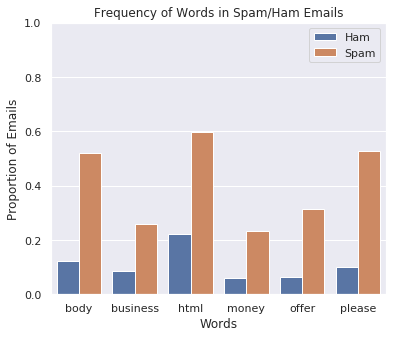

In [153]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

desired_words = ['body', 'business', 'html', 'money', 'offer', 'please']
emails = train['email']
arr = words_in_texts(desired_words, emails)
datas = pd.DataFrame(arr, columns = desired_words)
datas['type'] = train['spam']

#Pivot data
desired = datas.melt('type')

#Get the mean
desired_data = desired.groupby(['variable', 'type']).mean()

#Change pivot
desired_data.reset_index(inplace=True)  

#Rename in column Type
desired_data.replace({'type': {0: 'Ham', 1: 'Spam'}}, inplace=True)

#sns.set(rc={'figure.figsize':(6, 5)})
ax = sns.barplot(x = 'variable', y = 'value', hue = 'type', data=desired_data)

#Remove Title of Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])

#Set Labels and Titles
ax.set(xlabel='Words', ylabel='Proportion of Emails', title = 'Frequency of Words in Spam/Ham Emails')

#Set height limit
ax.set(ylim=(0, 1))

[(0, 1)]

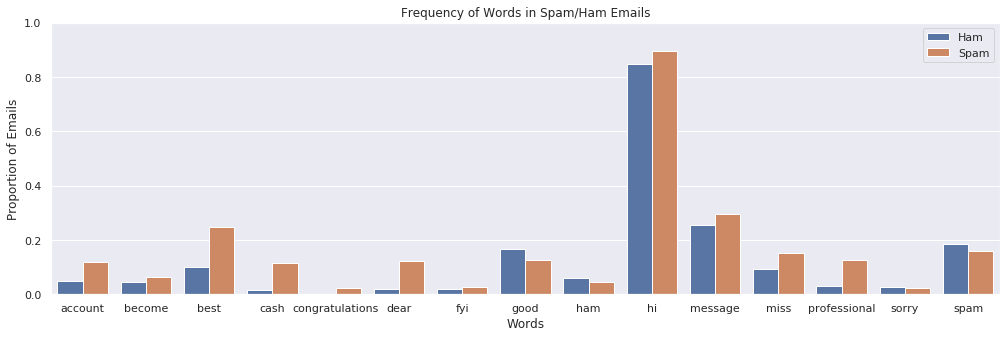

In [250]:
#THIS IS SO FUN. I WANT TO EXPLORE MORE WORDS
desired_words = ['congratulations', 'message', 'fyi', 'ham', 'spam', 'account', 'become', 'hi', 'dear', 'good', 'professional', 'best', 'cash', 'sorry', 'miss']
emails = train['email']
arr = words_in_texts(desired_words, emails)
datas = pd.DataFrame(arr, columns = desired_words)
datas['type'] = train['spam']

#Pivot data
desired = datas.melt('type')

#Get the mean
desired_data = desired.groupby(['variable', 'type']).mean()

#Change pivot
desired_data.reset_index(inplace=True)  

#Rename in column Type
desired_data.replace({'type': {0: 'Ham', 1: 'Spam'}}, inplace=True)

sns.set(rc={'figure.figsize':(17, 5)})
ax = sns.barplot(x = 'variable', y = 'value', hue = 'type', data=desired_data)

#Remove Title of Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])

#Set Labels and Titles
ax.set(xlabel='Words', ylabel='Proportion of Emails', title = 'Frequency of Words in Spam/Ham Emails')

#Set height limit
ax.set(ylim=(0, 1))

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
points: 2
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

In [219]:
target_spam = train.loc[train['spam'] == 1]
target_ham = train.loc[train['spam'] == 0]

In [220]:
target_ham

,id,subject,email,spam,length
0,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0,1641
1,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0,4713
2,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0,1399
3,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0,4435
4,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0,32857
...,...,...,...,...,...
7506,466,Subject: Re: [SAtalk] Badly Formatted Spam Rep...,"on wed, 11 sep 2002, vince puzzella wrote:\n \...",0,1342
7508,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""tp"" == tim peters <tim.one@comcast.net>...",0,465
7510,5390,Subject: Facts about sex.\n,\n forwarded-by: flower\n \n did you know that...,0,1732
7511,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"on tue, oct 08, 2002 at 04:36:13pm +0200, matt...",0,1098


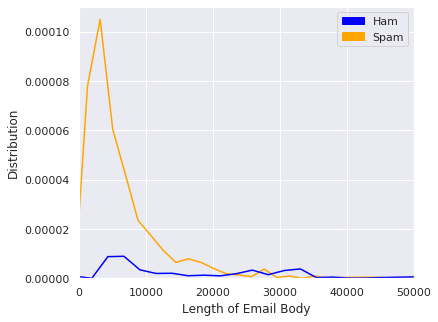

In [230]:
import matplotlib.patches as mpatches
ax = sns.distplot(target_spam['length'], color ='orange', hist=False)
ax = sns.distplot(target_ham['length'], color = 'blue', hist=False)
ax.set(xlim=(0, 50000), xlabel = 'Length of Email Body', ylabel = 'Distribution')
blue_patch = mpatches.Patch(color='blue', label='Ham')
yellow_patch = mpatches.Patch(color='orange', label='Spam')
plt.legend(handles=[blue_patch, yellow_patch])

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [231]:
words_in_texts(words, train['email'])

NameError: name 'words' is not defined

In [254]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [255]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver="lbfgs")
model.fit(X_train, Y_train)


def threshold_predict(model, X, threshold): 
    return np.where(lr_model.predict_proba(X)[:,1] > threshold, 1.0, 0.0)

def accuracy(threshold, X, Y):
    return np.mean(threshold_predict(lr_model, X, threshold) == Y)

#thresholds = np.linspace(0, 1, 100)
#accs = [accuracy(t, X, Y) for t in thresholds]

Y_pred = model.predict(X_train)

training_accuracy = accuracy_score(Y_train, Y_pred)

print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [265]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



You have trained your first logistic regression model and it can correctly classify around 76% of the training data! Can we do better than this? The answer is yes! In project 2B, you will learn to evaluate your classifier. Moreover, you will have the chance to extract your own features and build your own classifier!

## Submission
Congratulations! You are finished with this assignment. Please don't forget to submit by 11:59pm PST on Monday, 04/20!

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 3 EXPORTED QUESTIONS -->

In [266]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2a.ipynb', 'proj2a.pdf')
ok.submit()

Generating PDF...
Saved proj2a.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj2a.ipynb'.
Submit... 100% complete
Submission successful for user: letantruong32@berkeley.edu
URL: https://okpy.org/cal/data100/sp20/proj2a/submissions/wKK6z1

